In [1]:
# 导入相关包
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 导入预训练CNN
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import pandas as pd

import json
import tqdm
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# 打印版本
tf.__version__

'2.15.0'

In [3]:
path = r"D:\Study\UPenn\DeepLearning\Project"
root = r"D:\Study\UPenn\DeepLearning\Project\data\images\flickr30k_images"  # 图片文件夹的路径
ann_file = r"D:\Study\UPenn\DeepLearning\Project\张\results_20130124.token"  # 标注文件的路径

In [4]:
annotations = pd.read_table(ann_file, sep='\t', header=None,
                            names=['image', 'caption'])
print(annotations["image"])

0         1000092795.jpg#0
1         1000092795.jpg#1
2         1000092795.jpg#2
3         1000092795.jpg#3
4         1000092795.jpg#4
                ...       
158910     998845445.jpg#0
158911     998845445.jpg#1
158912     998845445.jpg#2
158913     998845445.jpg#3
158914     998845445.jpg#4
Name: image, Length: 158915, dtype: object


In [5]:
#annotations = annotations[0:1000]
#print(annotations["image"])

In [6]:
IMAGE_SIZE = (299, 299)
VOCAB_SIZE = 10000

SEQ_LENGTH = 30
EMBED_DIM = 512
FF_DIM = 512

BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
annotations

,image,caption
0,1000092795.jpg#0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg#1,"Two young , White males are outside near many ..."
2,1000092795.jpg#2,Two men in green shirts are standing in a yard .
3,1000092795.jpg#3,A man in a blue shirt standing in a garden .
4,1000092795.jpg#4,Two friends enjoy time spent together .
...,...,...
158910,998845445.jpg#0,A man in shorts and a Hawaiian shirt leans ove...
158911,998845445.jpg#1,"A young man hanging over the side of a boat , ..."
158912,998845445.jpg#2,A man is leaning off of the side of a blue and...
158913,998845445.jpg#3,"A man riding a small boat in a harbor , with f..."


In [8]:
from collections import defaultdict

In [9]:
token_len = []

def load_captions_json(data):

    caption_mapping = defaultdict(list)
    text_data = []
    images_to_skip = set()

    for index, row in tqdm.tqdm(data.iterrows()):
        image_id = row['image']
        cap = row['caption']
        img_name = image_id[:-2]
        img_name = os.path.join(root, img_name.strip())
        tokens = cap.split(" ")
        token_len.append(len(tokens))
        if len(tokens) < 3 or len(tokens) > SEQ_LENGTH:
            images_to_skip.add(img_name)
            continue
        if img_name.endswith("jpg") and img_name not in images_to_skip:
            caption = "<start> " + cap.strip(".").strip() + " <end>"
            caption_mapping[img_name].append(caption)
            text_data.append(caption)

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

    return caption_mapping, text_data

In [10]:
captions_mapping, text_data = load_captions_json(annotations)

158915it [00:14, 10627.32it/s]


In [11]:
def train_val_split(caption_data, train_size=0.8):
    # 分成训练集和测试集

    # 获取所有图片的文件名
    all_images = list(caption_data.keys())
    # 打乱顺序
    np.random.shuffle(all_images)

    # 分成训练集和测试集
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data

In [12]:
train_data, valid_data = train_val_split(captions_mapping)

In [13]:
len(train_data),len(valid_data)

(23935, 5984)

In [14]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")


vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

vectorization.adapt(text_data)

In [15]:
vectorization.get_vocabulary()

['',
 '[UNK]',
 'a',
 '<start>',
 '<end>',
 'in',
 'the',
 'on',
 'man',
 'and',
 'is',
 'of',
 'with',
 'woman',
 'two',
 'are',
 'people',
 'to',
 'at',
 'an',
 'wearing',
 'young',
 'white',
 'shirt',
 'black',
 'his',
 'while',
 'blue',
 'girl',
 'red',
 'dog',
 'boy',
 'sitting',
 'men',
 'standing',
 'playing',
 'street',
 'group',
 'down',
 'walking',
 'front',
 'her',
 'holding',
 'water',
 'one',
 'three',
 'by',
 'women',
 'child',
 'green',
 'up',
 'looking',
 'for',
 'little',
 'as',
 'large',
 'outside',
 'person',
 'children',
 'brown',
 'yellow',
 'through',
 'their',
 'from',
 'ball',
 'hat',
 'small',
 'into',
 'other',
 'over',
 'next',
 'running',
 'some',
 'out',
 'riding',
 'dressed',
 'building',
 'jacket',
 'another',
 'around',
 'orange',
 'field',
 'near',
 'beach',
 'crowd',
 'stands',
 'jumping',
 'sidewalk',
 'pink',
 'grass',
 'behind',
 'girls',
 'background',
 'snow',
 'table',
 'sits',
 'bike',
 'dogs',
 'asian',
 'air',
 'looks',
 'camera',
 'city',
 't

In [16]:
vectorization(['a man sleep'])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[   2,    8, 2078,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int64)>

In [17]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [18]:
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 30), dtype=tf.int64, name=None))>

In [19]:
vocab = np.array(vectorization.get_vocabulary())

[['<start>' 'three' 'men' 'are' 'standing' 'around' 'pack' 'horses' 'in'
  'front' 'of' 'a' 'red' 'tent' 'up' 'in' 'the' 'mountains' '<end>' '' ''
  '' '' '' '' '' '' '' '' '']
 ['<start>' 'the' 'riders' 'and' 'horses' 'are' 'taking' 'a' 'break'
  'and' 'resting' 'on' 'the' 'mountain' 'trail' '<end>' '' '' '' '' '' ''
  '' '' '' '' '' '' '' '']
 ['<start>' 'a' 'group' 'of' 'horses' 'and' 'people' 'in' 'front' 'of'
  'a' 'snowy' 'mountain' '<end>' '' '' '' '' '' '' '' '' '' '' '' '' ''
  '' '' '']
 ['<start>' 'three' 'riders' 'stand' 'around' 'their' 'horses' 'in' 'the'
  'mountains' '<end>' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
  '' '']
 ['<start>' 'two' 'men' 'and' 'some' 'horses' 'on' 'a' 'snowy' 'mountain'
  '<end>' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]


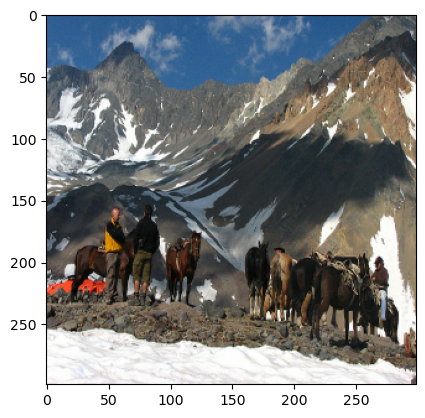

In [20]:
for i in train_dataset:
    img = i[0][0].numpy().astype('int')
    caption = i[1][0].numpy()
    plt.imshow(img)
    print(vocab[caption])


    break

In [21]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [22]:
cnn_model = get_cnn_model()

In [23]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 299, 299, 3)          0         ['normalization[0][0]']   

In [24]:
cnn_test_input = tf.random.normal([64, 299,299,3])
cnn_test_output = cnn_model(cnn_test_input, training=False)

In [25]:
cnn_test_output.shape

TensorShape([64, 100, 1280])

In [26]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # layer norm
        inputs = self.layernorm_1(inputs)

        inputs = self.dense_1(inputs)
        # multi head attention
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [27]:
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)

In [28]:
encoder_test_output = encoder(cnn_test_output, training=False)

In [29]:
encoder_test_output.shape

TensorShape([64, 100, 512])

In [30]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__()
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        # position_embeddings：
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))


    def call(self, inputs):
        length = tf.shape(inputs)[-1]

        positions = tf.range(start=0, limit=length, delta=1)

        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale

        embedded_positions = self.position_embeddings(positions)

        return embedded_tokens + embedded_positions


In [31]:
test_embedding_model = PositionalEmbedding(embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)

In [32]:
for i in train_dataset:

    caption = i[1][:,0,:-1]
    print(caption.shape)

    positional_output = test_embedding_model(caption)

    print(positional_output.shape)


    break

(64, 29)
(64, 29, 512)


In [33]:
class TransformerDecoderBlock(layers.Layer):

    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__()
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )

        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):

        inputs = self.embedding(inputs)

        causal_mask = self.get_causal_attention_mask(inputs)

        padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

        combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)

        combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)

        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        '''
        causal: 因果关系mask
        '''
        # (N,24,512)
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")

        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

        scale = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        result = tf.tile(mask, scale)

        return result

In [34]:
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

In [35]:
for i in train_dataset:
    batch_seq_inp = i[1][:,0,:-1]
    # print(batch_seq_inp.shape)

    batch_seq_true = i[1][:,0,1:]
    # print(batch_seq_true.shape)

    mask = tf.math.not_equal(batch_seq_true, 0)
    # print(mask.shape)

    batch_seq_pred = decoder(
        batch_seq_inp, encoder_test_output, training=False, mask=mask
    )

    print(batch_seq_pred.shape)
    break

(64, 29, 10000)


In [36]:
image_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)


In [37]:
total_train_loss, total_train_acc = list(), list()
total_valid_loss, total_valid_acc = list(), list()

class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):

        encoder_out = self.encoder(img_embed, training=training)

        # batch_seq的shape：(64, 25)
        batch_seq_inp = batch_seq[:, :-1]

        batch_seq_true = batch_seq[:, 1:]

        mask = tf.math.not_equal(batch_seq_true, 0)

        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )

        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):

        batch_img, batch_seq = batch_data

        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # batch_seq的shape：(64, 5, 25)
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                batch_loss += loss
                batch_acc += acc

            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            grads = tape.gradient(loss, train_vars)

            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        #total_train_loss.append(tf.keras.backend.eval(self.loss_tracker.result()))
        #total_train_acc.append(tf.keras.backend.eval(self.acc_tracker.result()))

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):

            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        #total_valid_loss.append(tf.keras.backend.eval(self.loss_tracker.result()))
        #total_valid_acc.append(tf.keras.backend.eval(self.acc_tracker.result()))

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [38]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [39]:
# loss
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)


In [40]:
from tensorflow.keras.callbacks import Callback

class CollectBatchStats(Callback):
    def __init__(self):
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs['loss'])
        self.train_acc.append(logs['acc'])
        self.val_loss.append(logs['val_loss'])
        self.val_acc.append(logs['val_acc'])

batch_stats_callback = CollectBatchStats()

caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, batch_stats_callback],
)

total_train_loss = batch_stats_callback.train_loss
total_train_acc = batch_stats_callback.train_acc
total_valid_loss = batch_stats_callback.val_loss
total_valid_acc = batch_stats_callback.val_acc

Epoch 1/30
374/374 [==============================] - 2625s 7s/step - loss: 24.3229 - acc: 0.1860 - val_loss: 18.4259 - val_acc: 0.3460
Epoch 2/30
374/374 [==============================] - 2595s 7s/step - loss: 17.8144 - acc: 0.3462 - val_loss: 16.6069 - val_acc: 0.3761
Epoch 3/30
374/374 [==============================] - 2602s 7s/step - loss: 16.4980 - acc: 0.3704 - val_loss: 15.8058 - val_acc: 0.3902
Epoch 4/30
374/374 [==============================] - 2601s 7s/step - loss: 15.7397 - acc: 0.3840 - val_loss: 15.3599 - val_acc: 0.3991
Epoch 5/30
374/374 [==============================] - 2680s 7s/step - loss: 15.2153 - acc: 0.3938 - val_loss: 15.0767 - val_acc: 0.4035
Epoch 6/30
374/374 [==============================] - 2711s 7s/step - loss: 14.8079 - acc: 0.4022 - val_loss: 14.9031 - val_acc: 0.4068
Epoch 7/30
374/374 [==============================] - 2473s 7s/step - loss: 14.4759 - acc: 0.4085 - val_loss: 14.7427 - val_acc: 0.4108
Epoch 8/30
374/374 [============================

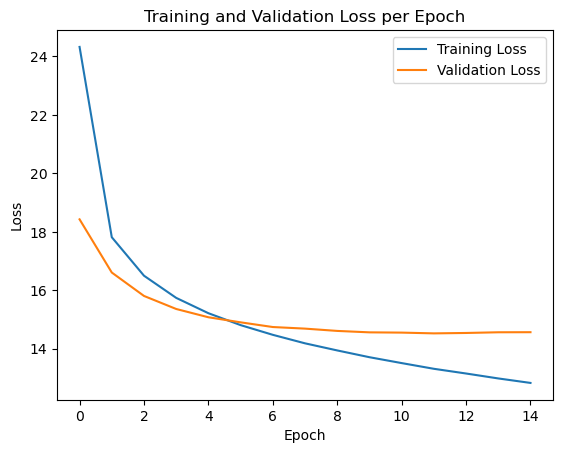

In [41]:
import matplotlib.pyplot as plt

# total_train_loss = [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, ...]

plt.plot(total_train_loss, label='Training Loss')
plt.plot(total_valid_loss, label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

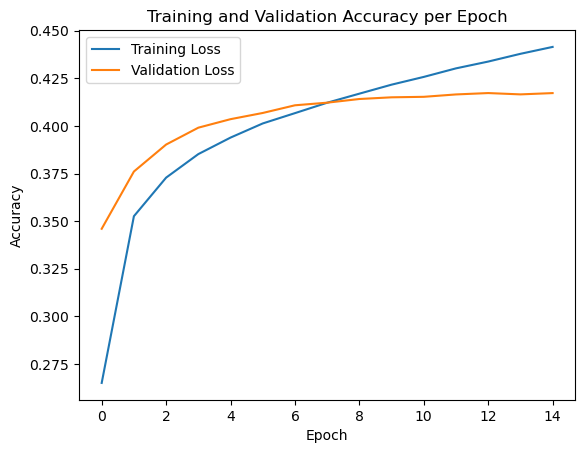

In [42]:
import matplotlib.pyplot as plt

# total_train_loss = [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, ...]

plt.plot(total_train_acc, label='Training Loss')
plt.plot(total_valid_acc, label='Validation Loss')

plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()


plt.show()

In [43]:
caption_model.save_weights(path + "/Model/checkpoint")

In [44]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())
valid_caption = list(valid_data.values())
valid_len = len(valid_images)

In [45]:
import cv2

In [46]:
import random
def generate_caption():
    random_index = random.randrange(0,valid_len)
    sample_img = valid_images[random_index]
    sample_caption = valid_caption[random_index][0]
    sample_img = decode_and_resize(sample_img)
    img_show = sample_img.numpy().clip(0, 255).astype(np.uint8)

    plt.imshow(img_show)
    plt.axis('off')
    plt.show()

    cv2.imwrite('./img/raw.jpg',cv2.cvtColor(img_show,cv2.COLOR_RGB2BGR))
    
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)

        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    sample_caption = sample_caption.replace("<start> ", "")
    sample_caption = sample_caption.replace(" <end>", "").strip()


    print("Predicted Caption: ", decoded_caption)
    print('Real Caption',sample_caption)

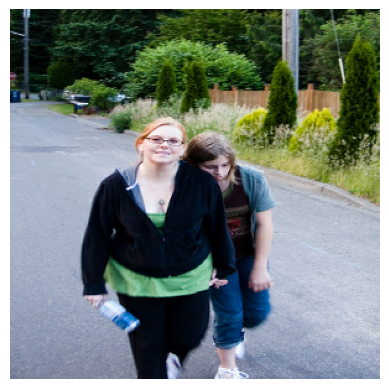

Predicted Caption:  a woman in a green jacket and blue jeans is walking down the street
Real Caption An red-haired older woman , holding a younger girl 's hand , looks at the camera


In [47]:
generate_caption()

In [48]:
def generate_caption_img(sample_img):
    # random_index = random.randrange(0,valid_len)
    # sample_img = valid_images[random_index]
    # sample_caption = valid_caption[random_index][0]
    print(sample_img)
    sample_img = decode_and_resize(sample_img)
    img_show = sample_img.numpy().clip(0, 255).astype(np.uint8)

    plt.imshow(img_show)
    plt.axis('off')
    plt.show()

    cv2.imwrite('./img/raw.jpg',cv2.cvtColor(img_show,cv2.COLOR_RGB2BGR))

    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)

        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    #sample_caption = sample_caption.replace("<start> ", "")
    #sample_caption = sample_caption.replace(" <end>", "").strip()


    print("Predicted Caption: ", decoded_caption)
    # print('Real Caption:',sample_caption)

D:\Study\UPenn\DeepLearning\Project\data\sample\1.png


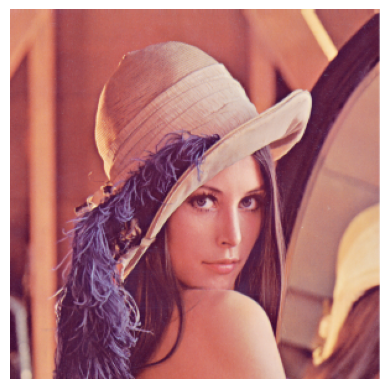

Predicted Caption:  a woman with a long brown hair is looking at her cellphone


In [49]:
img_path = r"D:\Study\UPenn\DeepLearning\Project\data\sample\1.png"
generate_caption_img(img_path)